Librerías

In [241]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import os
import matplotlib.ticker as ti
from itertools import islice
from scipy.special import wofz
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from scipy.signal import find_peaks

**Actividad 1**

Importación de datos

In [242]:
df = pd.read_csv("actividad 1.csv", delimiter=';', skiprows=2)
df.dropna(how='any', inplace=True)
df.columns = ["theta_deg", "intensity"]
df["theta_deg"] = df["theta_deg"].str.replace(",", ".").astype(float)
df["intensity"] = df["intensity"].astype(float)
df.head()


,theta_deg,intensity
0,15.0,389.0
1,15.1,384.0
2,15.2,389.0
3,15.3,370.0
4,15.4,387.0


Gráficas

In [243]:
desface_grados = 1.9 #°
desface_radianes = np.deg2rad(desface_grados) #rad
theta = df["theta_deg"].to_numpy() #°
intensity = df["intensity"].to_numpy() #u.a.
theta_rad = np.deg2rad(theta) #rad
theta_rad = theta_rad + desface_radianes #rad

d = 2.04e-10 #m
h = 6.626e-34 #J.s
c = 3e8 #m/s

In [244]:
def lambda_func(theta,n):
    f = 2 * d * np.sin(theta) #m
    return f/n

lambda_l = lambda_func(theta_rad,1) #m
lambda_a = lambda_l * 1e10 #nm
lambda_2 = lambda_func(theta_rad + 0*desface_radianes,2) #m
lambda_b = lambda_2 * 1e10 #nm

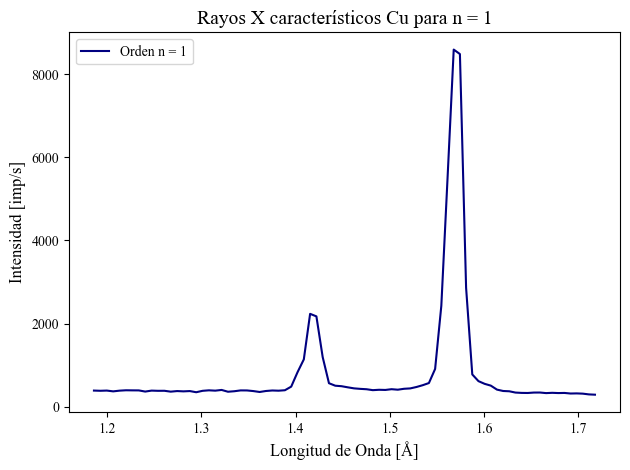

In [245]:
plt.plot(lambda_a, intensity, label='Orden n = 1', color='navy', linewidth=1.5)

plt.xlabel('Longitud de Onda [Å]', fontsize=12)
plt.ylabel('Intensidad [imp/s]', fontsize=12)
plt.title('Rayos X característicos Cu para n = 1', fontsize=14)

plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

In [246]:
# Encontrar índices de los picos en la señal de intensidad
peaks_indices, _ = find_peaks(intensity, height=1000)  # Ajusta el umbral 'height' según tu caso

# Obtener las posiciones en el eje X correspondientes a esos picos
peaks_x = lambda_a[peaks_indices]
peaks_y = intensity[peaks_indices]

# Imprimir resultados
for i, (x, y) in enumerate(zip(peaks_x, peaks_y), 1):
    print(f"Pico {i}: λ = {x:.4f} Å, Intensidad = {y:.1f} imp/s")

Pico 1: λ = 1.4155 Å, Intensidad = 2235.0 imp/s
Pico 2: λ = 1.5679 Å, Intensidad = 8592.0 imp/s


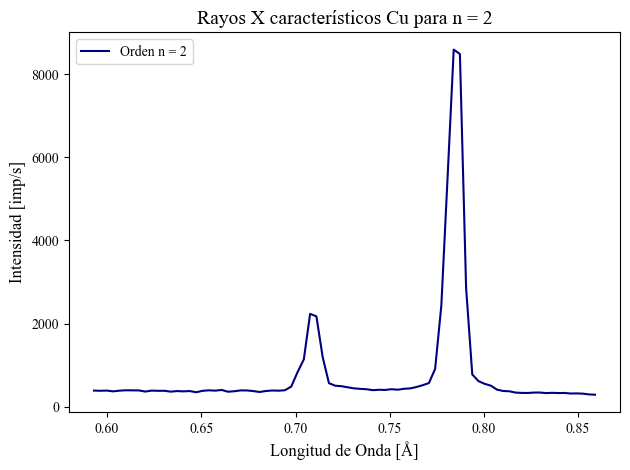

In [247]:
plt.plot(lambda_b, intensity, label='Orden n = 2', color='navy', linewidth=1.5)

plt.xlabel('Longitud de Onda [Å]', fontsize=12)
plt.ylabel('Intensidad [imp/s]', fontsize=12)
plt.title('Rayos X característicos Cu para n = 2', fontsize=14)

plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

In [248]:
# Encontrar índices de los picos en la señal de intensidad
peaks_indices, _ = find_peaks(intensity, height=1000)  # Ajusta el umbral 'height' según tu caso

# Obtener las posiciones en el eje X correspondientes a esos picos
peaks_x = lambda_b[peaks_indices]
peaks_y = intensity[peaks_indices]

# Imprimir resultados
for i, (x, y) in enumerate(zip(peaks_x, peaks_y), 1):
    print(f"Pico {i}: λ = {x:.4f} Å, Intensidad = {y:.1f} imp/s")

Pico 1: λ = 0.7077 Å, Intensidad = 2235.0 imp/s
Pico 2: λ = 0.7840 Å, Intensidad = 8592.0 imp/s


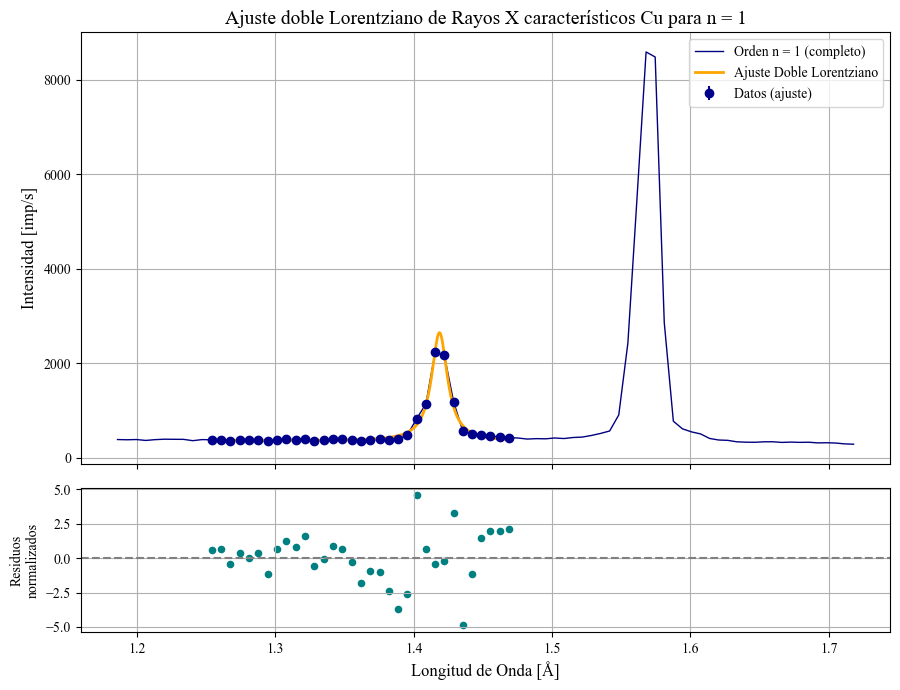

In [249]:
# Ajuste de la curva de Lorentziana
# Función: suma de dos lorentzianas
def double_lorentzian(x, A1, x01, gamma1, A2, x02, gamma2):
    L1 = A1 / (1 + ((x - x01) / gamma1)**2)
    L2 = A2 / (1 + ((x - x02) / gamma2)**2)
    return L1 + L2

# Ventana que cubre ambos picos
idx_fit = (lambda_a > 1.25) & (lambda_a < 1.47)
x_data = lambda_a[idx_fit]
y_data = intensity[idx_fit]

# Error Poissoniano
errors = np.sqrt(y_data)
errors[errors == 0] = 1  # Evita división por cero

# Estimaciones iniciales: [A1, x01, gamma1, A2, x02, gamma2]
p0 = [2000, 1.29, 0.01, 9000, 1.43, 0.01]

# Ajuste con pesos
popt, pcov = curve_fit(double_lorentzian, x_data, y_data, p0=p0,
                       sigma=errors, absolute_sigma=True, maxfev=10000)

# Evaluar ajuste
x_fit = np.linspace(min(x_data), max(x_data), 800)
y_fit = double_lorentzian(x_fit, *popt)

# Residuos normalizados
residuals = y_data - double_lorentzian(x_data, *popt)
normalized_residuals = residuals / errors

# === GRAFICAR ===
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 7), sharex=True,
                               gridspec_kw={'height_ratios': [3, 1]})

# Curva completa
ax1.plot(lambda_a, intensity, label='Orden n = 1 (completo)', color='navy', linewidth=1)

# Datos experimentales (puntos con barras de error)
ax1.errorbar(x_data, y_data, yerr=errors, fmt='o', color='darkblue', label='Datos (ajuste)')

# Curva ajustada
ax1.plot(x_fit, y_fit, color='orange', linewidth=2, label='Ajuste Doble Lorentziano')

ax1.set_ylabel('Intensidad [imp/s]', fontsize=12)
ax1.set_title('Ajuste doble Lorentziano de Rayos X característicos Cu para n = 1', fontsize=14)
ax1.legend()
ax1.grid(True)

# Gráfico de residuos
ax2.axhline(0, color='gray', linestyle='--')
ax2.scatter(x_data, normalized_residuals, color='teal', s=20)
ax2.set_xlabel('Longitud de Onda [Å]', fontsize=12)
ax2.set_ylabel('Residuos\nnormalizados', fontsize=10)
ax2.grid(True)

plt.tight_layout()
plt.show()


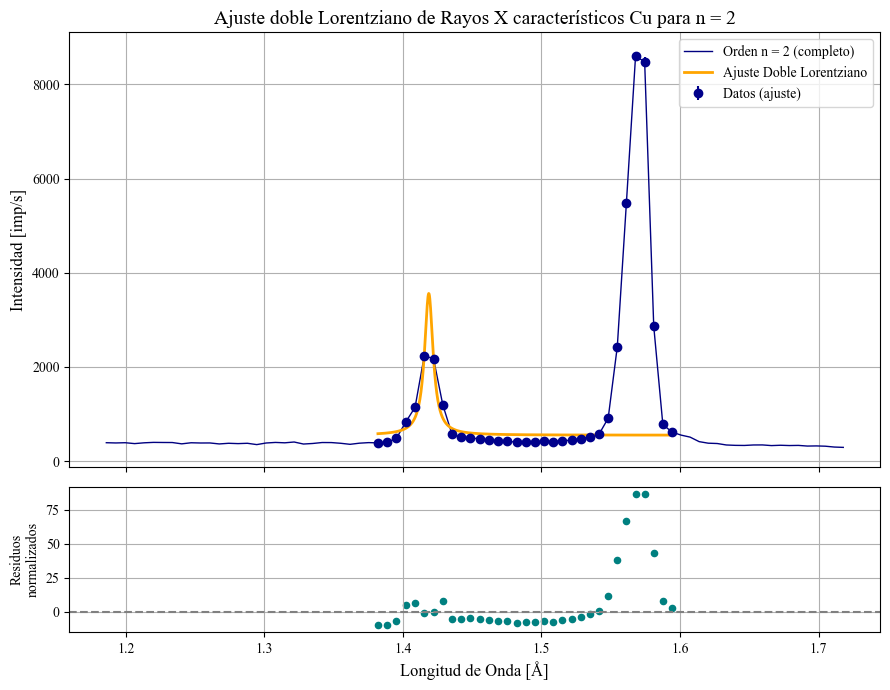

In [250]:
# Ajuste de la curva de Lorentziana
# Función: suma de dos lorentzianas
def double_lorentzian(x, A1, x01, gamma1, A2, x02, gamma2):
    L1 = A1 / (1 + ((x - x01) / gamma1)**2)
    L2 = A2 / (1 + ((x - x02) / gamma2)**2)
    return L1 + L2

# Ventana que cubre ambos picos
idx_fit = (lambda_b > 0.69) & (lambda_b < 0.8)
x_data = lambda_a[idx_fit]
y_data = intensity[idx_fit]

# Error Poissoniano
errors = np.sqrt(y_data)
errors[errors == 0] = 1  # Evita división por cero

# Estimaciones iniciales: [A1, x01, gamma1, A2, x02, gamma2]
p0 = [2000, 1.29, 0.01, 9000, 1.43, 0.01]

# Ajuste con pesos
popt, pcov = curve_fit(double_lorentzian, x_data, y_data, p0=p0,
                       sigma=errors, absolute_sigma=True, maxfev=10000)

# Evaluar ajuste
x_fit = np.linspace(min(x_data), max(x_data), 800)
y_fit = double_lorentzian(x_fit, *popt)

# Residuos normalizados
residuals = y_data - double_lorentzian(x_data, *popt)
normalized_residuals = residuals / errors

# === GRAFICAR ===
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 7), sharex=True,
                               gridspec_kw={'height_ratios': [3, 1]})

# Curva completa
ax1.plot(lambda_a, intensity, label='Orden n = 2 (completo)', color='navy', linewidth=1)

# Datos experimentales (puntos con barras de error)
ax1.errorbar(x_data, y_data, yerr=errors, fmt='o', color='darkblue', label='Datos (ajuste)')

# Curva ajustada
ax1.plot(x_fit, y_fit, color='orange', linewidth=2, label='Ajuste Doble Lorentziano')

ax1.set_ylabel('Intensidad [imp/s]', fontsize=12)
ax1.set_title('Ajuste doble Lorentziano de Rayos X característicos Cu para n = 2', fontsize=14)
ax1.legend()
ax1.grid(True)

# Gráfico de residuos
ax2.axhline(0, color='gray', linestyle='--')
ax2.scatter(x_data, normalized_residuals, color='teal', s=20)
ax2.set_xlabel('Longitud de Onda [Å]', fontsize=12)
ax2.set_ylabel('Residuos\nnormalizados', fontsize=10)
ax2.grid(True)

plt.tight_layout()
plt.show()

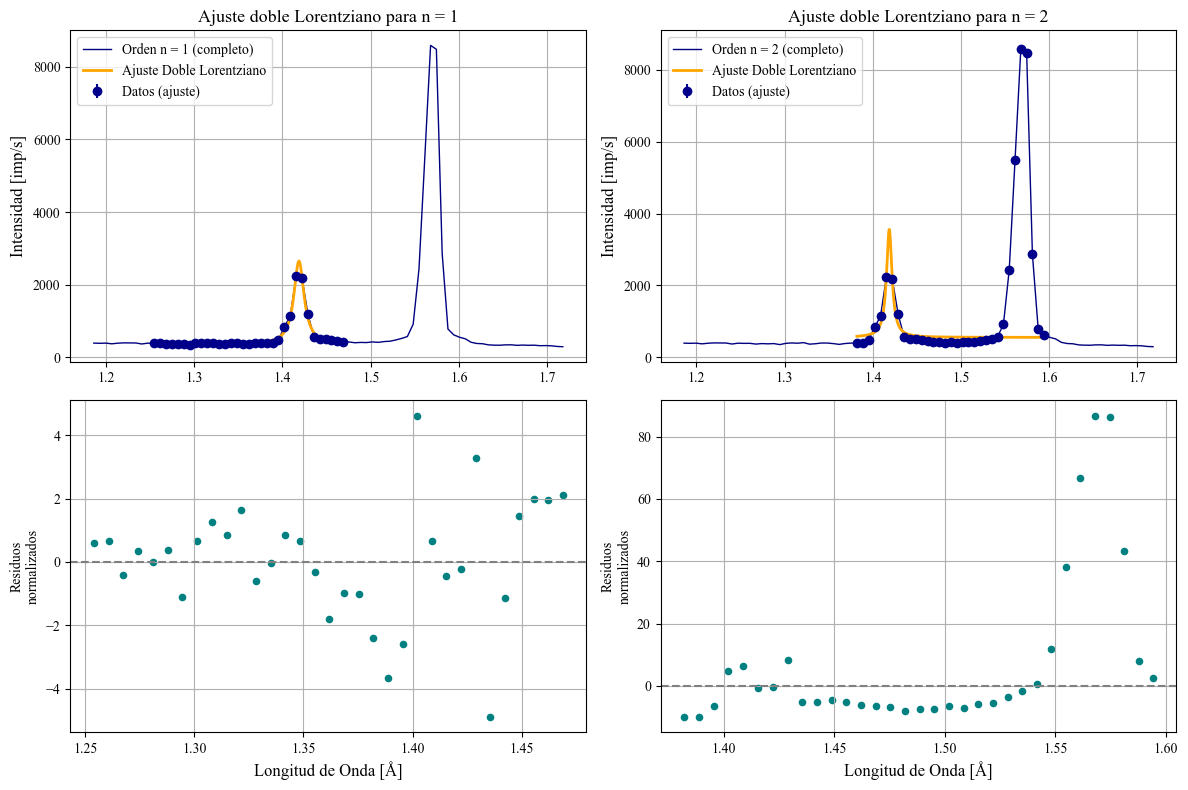

In [251]:
# Función doble lorentziana
def double_lorentzian(x, A1, x01, gamma1, A2, x02, gamma2):
    L1 = A1 / (1 + ((x - x01) / gamma1)**2)
    L2 = A2 / (1 + ((x - x02) / gamma2)**2)
    return L1 + L2

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False)

# ========================= Gráfica para n = 1 =========================
idx_fit1 = (lambda_a > 1.25) & (lambda_a < 1.47)
x1 = lambda_a[idx_fit1]
y1 = intensity[idx_fit1]
errors1 = np.sqrt(y1)
errors1[errors1 == 0] = 1
p0 = [2000, 1.29, 0.01, 9000, 1.43, 0.01]
popt1, pcov1 = curve_fit(double_lorentzian, x1, y1, p0=p0, sigma=errors1, absolute_sigma=True, maxfev=10000)
x_fit1 = np.linspace(min(x1), max(x1), 800)
y_fit1 = double_lorentzian(x_fit1, *popt1)
residuals1 = y1 - double_lorentzian(x1, *popt1)
norm_res1 = residuals1 / errors1

ax1_curve = axes[0, 0]
ax1_resid = axes[1, 0]

ax1_curve.plot(lambda_a, intensity, label='Orden n = 1 (completo)', color='navy', linewidth=1)
ax1_curve.errorbar(x1, y1, yerr=errors1, fmt='o', color='darkblue', label='Datos (ajuste)')
ax1_curve.plot(x_fit1, y_fit1, color='orange', linewidth=2, label='Ajuste Doble Lorentziano')
ax1_curve.set_ylabel('Intensidad [imp/s]', fontsize=12)
ax1_curve.set_title('Ajuste doble Lorentziano para n = 1', fontsize=13)
ax1_curve.legend()
ax1_curve.grid(True)

ax1_resid.axhline(0, color='gray', linestyle='--')
ax1_resid.scatter(x1, norm_res1, color='teal', s=20)
ax1_resid.set_xlabel('Longitud de Onda [Å]', fontsize=12)
ax1_resid.set_ylabel('Residuos\nnormalizados', fontsize=10)
ax1_resid.grid(True)

# ========================= Gráfica para n = 2 =========================
idx_fit2 = (lambda_b > 0.69) & (lambda_b < 0.8)
x2 = lambda_a[idx_fit2]
y2 = intensity[idx_fit2]
errors2 = np.sqrt(y2)
errors2[errors2 == 0] = 1
popt2, pcov2 = curve_fit(double_lorentzian, x2, y2, p0=p0, sigma=errors2, absolute_sigma=True, maxfev=10000)
x_fit2 = np.linspace(min(x2), max(x2), 800)
y_fit2 = double_lorentzian(x_fit2, *popt2)
residuals2 = y2 - double_lorentzian(x2, *popt2)
norm_res2 = residuals2 / errors2

ax2_curve = axes[0, 1]
ax2_resid = axes[1, 1]

ax2_curve.plot(lambda_a, intensity, label='Orden n = 2 (completo)', color='navy', linewidth=1)
ax2_curve.errorbar(x2, y2, yerr=errors2, fmt='o', color='darkblue', label='Datos (ajuste)')
ax2_curve.plot(x_fit2, y_fit2, color='orange', linewidth=2, label='Ajuste Doble Lorentziano')
ax2_curve.set_ylabel('Intensidad [imp/s]', fontsize=12)
ax2_curve.set_title('Ajuste doble Lorentziano para n = 2', fontsize=13)
ax2_curve.legend()
ax2_curve.grid(True)

ax2_resid.axhline(0, color='gray', linestyle='--')
ax2_resid.scatter(x2, norm_res2, color='teal', s=20)
ax2_resid.set_xlabel('Longitud de Onda [Å]', fontsize=12)
ax2_resid.set_ylabel('Residuos\nnormalizados', fontsize=10)
ax2_resid.grid(True)

plt.tight_layout()
plt.show()

# === FUNCIÓN DE AJUSTE ===
def double_voigt(x, A1, x01, sigma1, gamma1, A2, x02, sigma2, gamma2):
    z1 = (x - x01 + 1j * gamma1) / (sigma1 * np.sqrt(2))
    z2 = (x - x02 + 1j * gamma2) / (sigma2 * np.sqrt(2))
    V1 = A1 * np.real(wofz(z1))
    V2 = A2 * np.real(wofz(z2))
    return V1 + V2

# Ventana que cubre ambos picos
idx_fit = (lambda_a > 1.25) & (lambda_a < 1.47)
x_data = lambda_a[idx_fit]
y_data = intensity[idx_fit]

# Error Poissoniano
errors = np.sqrt(y_data)
errors[errors == 0] = 1  # Evita división por cero

# Estimaciones iniciales: [A1, x01, sigma1, gamma1, A2, x02, sigma2, gamma2]
p0 = [2000, 1.29, 0.005, 0.005, 9000, 1.43, 0.005, 0.005]

# Ajuste con pesos
popt, pcov = curve_fit(double_voigt, x_data, y_data, p0=p0,
                       sigma=errors, absolute_sigma=True, maxfev=20000)

# Evaluar ajuste
x_fit = np.linspace(min(x_data), max(x_data), 800)
y_fit = double_voigt(x_fit, *popt)

# Residuos normalizados
residuals = y_data - double_voigt(x_data, *popt)
normalized_residuals = residuals / errors

# === GRAFICAR ===
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 7), sharex=True,
                               gridspec_kw={'height_ratios': [3, 1]})

# Curva completa
ax1.plot(lambda_a, intensity, label='Orden n = 1 (completo)', color='navy', linewidth=1)

# Datos experimentales (puntos con barras de error)
ax1.errorbar(x_data, y_data, yerr=errors, fmt='o', color='darkblue', label='Datos (ajuste)')

# Curva ajustada
ax1.plot(x_fit, y_fit, color='orange', linewidth=2, label='Ajuste Doble Voigt')

ax1.set_ylabel('Intensidad [imp/s]', fontsize=12)
ax1.set_title('Ajuste doble Voigt de Rayos X característicos Cu para n = 1', fontsize=14)
ax1.legend()
ax1.grid(True)

# Gráfico de residuos
ax2.axhline(0, color='gray', linestyle='--')
ax2.scatter(x_data, normalized_residuals, color='teal', s=20)
ax2.set_xlabel('Longitud de Onda [Å]', fontsize=12)
ax2.set_ylabel('Residuos\nnormalizados', fontsize=10)
ax2.grid(True)

plt.tight_layout()
plt.show()



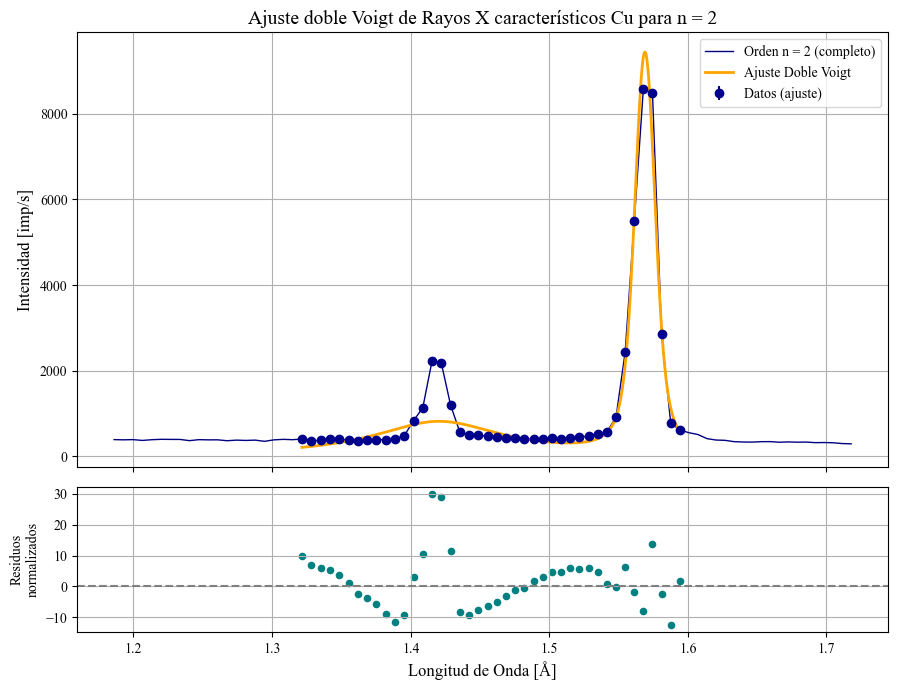

In [252]:
# === FUNCIÓN DE AJUSTE ===
def double_voigt(x, A1, x01, sigma1, gamma1, A2, x02, sigma2, gamma2):
    z1 = (x - x01 + 1j * gamma1) / (sigma1 * np.sqrt(2))
    z2 = (x - x02 + 1j * gamma2) / (sigma2 * np.sqrt(2))
    V1 = A1 * np.real(wofz(z1))
    V2 = A2 * np.real(wofz(z2))
    return V1 + V2

# Ventana que cubre ambos picos
idx_fit = (lambda_b > 0.66) & (lambda_b < 0.8)
x_data = lambda_a[idx_fit]
y_data = intensity[idx_fit]

# Error Poissoniano
errors = np.sqrt(y_data)
errors[errors == 0] = 1  # Evita división por cero

# Estimaciones iniciales: [A1, x01, sigma1, gamma1, A2, x02, sigma2, gamma2]
p0 = [2000, 0.715, 0.005, 0.005, 9000, 0.785, 0.005, 0.005]

# Ajuste con pesos
popt, pcov = curve_fit(double_voigt, x_data, y_data, p0=p0,
                       sigma=errors, absolute_sigma=True, maxfev=20000)

# Evaluar ajuste
x_fit = np.linspace(min(x_data), max(x_data), 800)
y_fit = double_voigt(x_fit, *popt)

# Residuos normalizados
residuals = y_data - double_voigt(x_data, *popt)
normalized_residuals = residuals / errors

# === GRAFICAR ===
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 7), sharex=True,
                               gridspec_kw={'height_ratios': [3, 1]})

# Curva completa
ax1.plot(lambda_a, intensity, label='Orden n = 2 (completo)', color='navy', linewidth=1)

# Datos experimentales (puntos con barras de error)
ax1.errorbar(x_data, y_data, yerr=errors, fmt='o', color='darkblue', label='Datos (ajuste)')

# Curva ajustada
ax1.plot(x_fit, y_fit, color='orange', linewidth=2, label='Ajuste Doble Voigt')

ax1.set_ylabel('Intensidad [imp/s]', fontsize=12)
ax1.set_title('Ajuste doble Voigt de Rayos X característicos Cu para n = 2', fontsize=14)
ax1.legend()
ax1.grid(True)

# Gráfico de residuos
ax2.axhline(0, color='gray', linestyle='--')
ax2.scatter(x_data, normalized_residuals, color='teal', s=20)
ax2.set_xlabel('Longitud de Onda [Å]', fontsize=12)
ax2.set_ylabel('Residuos\nnormalizados', fontsize=10)
ax2.grid(True)

plt.tight_layout()
plt.show()


# === FUNCIÓN DE AJUSTE ===
def double_voigt(x, A1, x01, sigma1, gamma1, A2, x02, sigma2, gamma2):
    z1 = (x - x01 + 1j * gamma1) / (sigma1 * np.sqrt(2))
    z2 = (x - x02 + 1j * gamma2) / (sigma2 * np.sqrt(2))
    V1 = A1 * np.real(wofz(z1))
    V2 = A2 * np.real(wofz(z2))
    return V1 + V2

# === INICIALIZAR FIGURA ===
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False)

# ===== AJUSTE PARA n = 1 =====
idx_fit1 = (lambda_a > 1.25) & (lambda_a < 1.47)
x1 = lambda_a[idx_fit1]
y1 = intensity[idx_fit1]
errors1 = np.sqrt(y1)
errors1[errors1 == 0] = 1
p0_1 = [2000, 1.29, 0.005, 0.005, 9000, 1.43, 0.005, 0.005]
popt1, pcov1 = curve_fit(double_voigt, x1, y1, p0=p0_1, sigma=errors1, absolute_sigma=True, maxfev=20000)
x_fit1 = np.linspace(min(x1), max(x1), 800)
y_fit1 = double_voigt(x_fit1, *popt1)
res1 = (y1 - double_voigt(x1, *popt1)) / errors1

ax1 = axes[0, 0]
ax1r = axes[1, 0]

ax1.plot(lambda_a, intensity, label='Orden n = 1 (completo)', color='navy', linewidth=1)
ax1.errorbar(x1, y1, yerr=errors1, fmt='o', color='darkblue', label='Datos (ajuste)')
ax1.plot(x_fit1, y_fit1, color='orange', linewidth=2, label='Ajuste Doble Voigt')
ax1.set_ylabel('Intensidad [imp/s]', fontsize=12)
ax1.set_title('Ajuste doble Voigt para n = 1', fontsize=13)
ax1.legend()
ax1.grid(True)

ax1r.axhline(0, color='gray', linestyle='--')
ax1r.scatter(x1, res1, color='teal', s=20)
ax1r.set_xlabel('Longitud de Onda [Å]', fontsize=12)
ax1r.set_ylabel('Residuos\nnormalizados', fontsize=10)
ax1r.grid(True)

# ===== AJUSTE PARA n = 2 =====
idx_fit2 = (lambda_b > 0.66) & (lambda_b < 0.8)
x2 = lambda_a[idx_fit2]
y2 = intensity[idx_fit2]
errors2 = np.sqrt(y2)
errors2[errors2 == 0] = 1
p0_2 = [2000, 0.715, 0.005, 0.005, 9000, 0.785, 0.005, 0.005]
popt2, pcov2 = curve_fit(double_voigt, x2, y2, p0=p0_2, sigma=errors2, absolute_sigma=True, maxfev=20000)
x_fit2 = np.linspace(min(x2), max(x2), 800)
y_fit2 = double_voigt(x_fit2, *popt2)
res2 = (y2 - double_voigt(x2, *popt2)) / errors2

ax2 = axes[0, 1]
ax2r = axes[1, 1]

ax2.plot(lambda_a, intensity, label='Orden n = 2 (completo)', color='navy', linewidth=1)
ax2.errorbar(x2, y2, yerr=errors2, fmt='o', color='darkblue', label='Datos (ajuste)')
ax2.plot(x_fit2, y_fit2, color='orange', linewidth=2, label='Ajuste Doble Voigt')
ax2.set_ylabel('Intensidad [imp/s]', fontsize=12)
ax2.set_title('Ajuste doble Voigt para n = 2', fontsize=13)
ax2.legend()
ax2.grid(True)

ax2r.axhline(0, color='gray', linestyle='--')
ax2r.scatter(x2, res2, color='teal', s=20)
ax2r.set_xlabel('Longitud de Onda [Å]', fontsize=12)
ax2r.set_ylabel('Residuos\nnormalizados', fontsize=10)
ax2r.grid(True)

plt.tight_layout()
plt.show()

Valores teóricos

Valores experimentales

In [253]:
E_exp_a1 = h * c / (1.54 * 1e-9) #J
E_exp_b1 = h * c / (1.39221 * 1e-9) #J

E_exp_a2 = h * c / (0.7840 * 1e-9) #J
E_exp_b2 = h * c / (0.7077 * 1e-9) #J

print(E_exp_a1) 
print(E_exp_b1) 

print(E_exp_a2)
print(E_exp_b2) 

1.2907792207792207e-16
1.427801840239619e-16
2.5354591836734694e-16
2.8088172954641797e-16


**Actividad 2**

**Actividad 4**

In [254]:
data = pd.read_csv("Actividad 4- Rayos X.csv",  encoding="latin1", delim_whitespace=True)
data = data.rename(columns={
    "Ángulo":"angulo",
    "del":"23kV1",
    "crista":"25kV1",
    "Tasa":"27kV1",
    "con":"29kV1",
    "23kV":"31kV1",
    "Tasa.1":"33kV1",
    "con.1":"35kV1"
})

data = data.to_numpy()
#angulo = data['angulo'].to_numpy()[1:]
data = data[1:,:8].T
data


C:\Users\Nekomou\AppData\Local\Temp\ipykernel_12460\2517944793.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv("Actividad 4- Rayos X.csv",  encoding="latin1", delim_whitespace=True)


array([['14,0', '14,1', '14,2', '14,3', '14,4', '14,5', '14,6', '14,7',
        '14,8', '14,9', '15,0', '15,1', '15,2', '15,3', '15,4', '15,5',
        '15,6', '15,7', '15,8', '15,9', '16,0', '16,1', '16,2', '16,3',
        '16,4', '16,5', '16,6', '16,7', '16,8', '16,9', '17,0', '17,1',
        '17,2', '17,3', '17,4', '17,5', '17,6', '17,7', '17,8', '17,9',
        '18,0', '18,1', '18,2', '18,3', '18,4', '18,5', '18,6', '18,7',
        '18,8', '18,9', '19,0', '19,1', '19,2', '19,3', '19,4', '19,5',
        '19,6', '19,7', '19,8', '19,9', '20,0', '20,1', '20,2', '20,3',
        '20,4', '20,5', '20,6', '20,7', '20,8', '20,9', '21,0', '21,1',
        '21,2', '21,3', '21,4', '21,5', '21,6', '21,7', '21,8', '21,9',
        '22,0', '22,1', '22,2', '22,3', '22,4', '22,5', '22,6', '22,7',
        '22,8', '22,9', '23,0', '23,1', '23,2', '23,3', '23,4', '23,5',
        '23,6', '23,7', '23,8', '23,9', '24,0', '24,1', '24,2', '24,3',
        '24,4', '24,5', '24,6', '24,7', '24,8', '24,9', '25,0'],

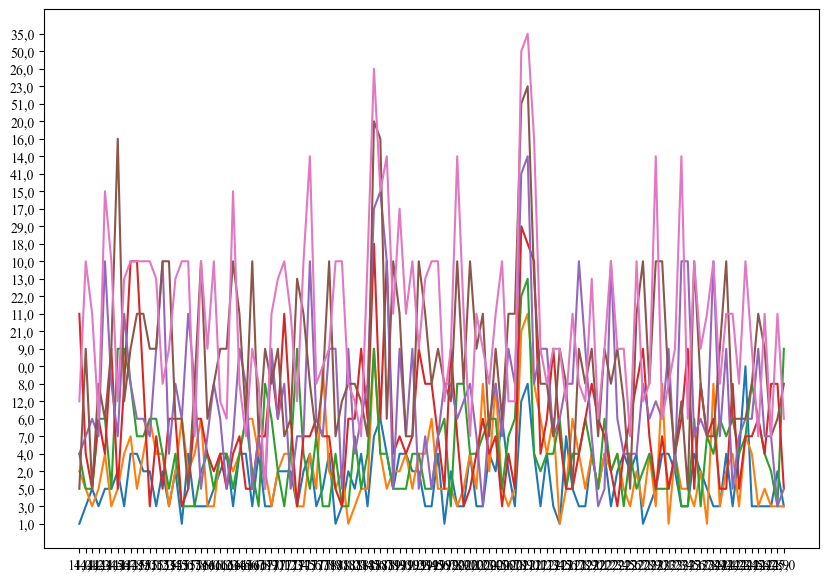

In [255]:
plt.rc('font', family='Times New Roman')
plt.figure(figsize = (10, 7))
for i in range(len(data)-1):
    plt.plot(data[0], data[i+1])

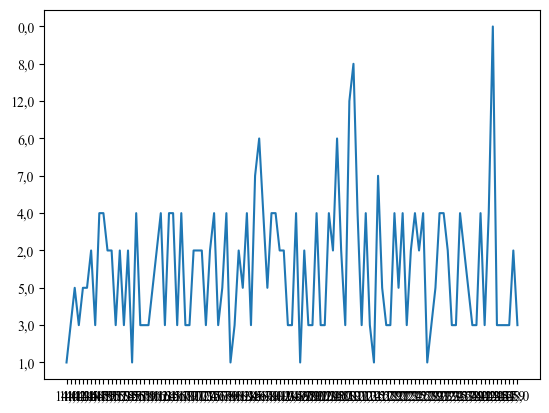

In [256]:
plt.plot(data[0], data[1])

C:\Users\Nekomou\AppData\Local\Temp\ipykernel_12460\662358271.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv("Actividad 4- Rayos X.csv", encoding="latin1", delim_whitespace=True)


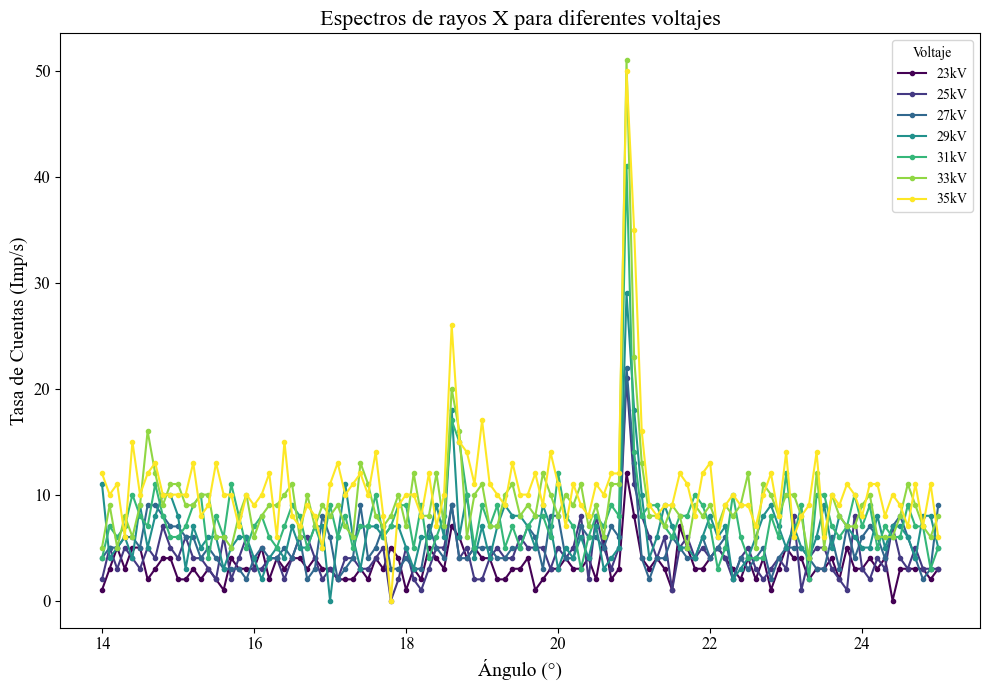

In [257]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Leer datos
data = pd.read_csv("Actividad 4- Rayos X.csv", encoding="latin1", delim_whitespace=True)
data = data.rename(columns={
    "Ángulo":"angulo",
    "del":"23kV1",
    "crista":"25kV1",
    "Tasa":"27kV1",
    "con":"29kV1",
    "23kV":"31kV1",
    "Tasa.1":"33kV1",
    "con.1":"35kV1"
})

# Convertir a numpy y transponer
data = data.to_numpy()
data = data[1:, :8].T

# Convertir eje x (ángulo) a flotante
x = np.array([float(str(a).replace(',', '.')) for a in data[0]])

# Estética
plt.rc('font', family='Times New Roman')
plt.figure(figsize=(10, 7))

# Etiquetas
labels = ["23kV", "25kV", "27kV", "29kV", "31kV", "33kV", "35kV"]
colors = plt.cm.viridis(np.linspace(0, 1, len(labels)))
data_ = data.copy()
# Graficar curvas
for i in range(1, len(data)):
    y = np.array([float(str(val).replace(',', '.')) for val in data[i]])
    data_[i] = y
    plt.plot(x, y, label=labels[i-1], color=colors[i-1], marker='o', markersize=3)

# Personalización
plt.xlabel("Ángulo (°)", fontsize=14)
plt.ylabel("Tasa de Cuentas (Imp/s)", fontsize=14)
plt.title("Espectros de rayos X para diferentes voltajes", fontsize=16)
plt.legend(title="Voltaje", fontsize=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()



Calcular lambdas

In [258]:
data_float = np.vectorize(lambda x: float(str(x).replace(',', '.')))(data)
data_float

array([[14. , 14.1, 14.2, 14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15. ,
        15.1, 15.2, 15.3, 15.4, 15.5, 15.6, 15.7, 15.8, 15.9, 16. , 16.1,
        16.2, 16.3, 16.4, 16.5, 16.6, 16.7, 16.8, 16.9, 17. , 17.1, 17.2,
        17.3, 17.4, 17.5, 17.6, 17.7, 17.8, 17.9, 18. , 18.1, 18.2, 18.3,
        18.4, 18.5, 18.6, 18.7, 18.8, 18.9, 19. , 19.1, 19.2, 19.3, 19.4,
        19.5, 19.6, 19.7, 19.8, 19.9, 20. , 20.1, 20.2, 20.3, 20.4, 20.5,
        20.6, 20.7, 20.8, 20.9, 21. , 21.1, 21.2, 21.3, 21.4, 21.5, 21.6,
        21.7, 21.8, 21.9, 22. , 22.1, 22.2, 22.3, 22.4, 22.5, 22.6, 22.7,
        22.8, 22.9, 23. , 23.1, 23.2, 23.3, 23.4, 23.5, 23.6, 23.7, 23.8,
        23.9, 24. , 24.1, 24.2, 24.3, 24.4, 24.5, 24.6, 24.7, 24.8, 24.9,
        25. ],
       [ 1. ,  3. ,  5. ,  3. ,  5. ,  5. ,  2. ,  3. ,  4. ,  4. ,  2. ,
         2. ,  3. ,  2. ,  3. ,  2. ,  1. ,  4. ,  3. ,  3. ,  3. ,  5. ,
         2. ,  4. ,  3. ,  4. ,  4. ,  3. ,  4. ,  3. ,  3. ,  2. ,  2. ,
         2. ,  3. ,  2.

In [259]:
def bragg(angulo):
    return 2 * d * np.sin(np.radians(angulo)) * 1e10 #nm

lambda_ = bragg(data_float[0])


In [260]:
lambda_

array([0.98704133, 0.99394925, 1.00085413, 1.00775597, 1.01465474,
       1.02155042, 1.02844298, 1.03533241, 1.04221869, 1.0491018 ,
       1.0559817 , 1.0628584 , 1.06973185, 1.07660204, 1.08346896,
       1.09033257, 1.09719287, 1.10404982, 1.11090341, 1.11775361,
       1.12460041, 1.13144379, 1.13828371, 1.14512017, 1.15195314,
       1.15878261, 1.16560854, 1.17243092, 1.17924973, 1.18606495,
       1.19287656, 1.19968453, 1.20648884, 1.21328949, 1.22008643,
       1.22687966, 1.23366915, 1.24045489, 1.24723684, 1.254015  ,
       1.26078934, 1.26755983, 1.27432647, 1.28108922, 1.28784807,
       1.294603  , 1.30135398, 1.308101  , 1.31484404, 1.32158307,
       1.32831807, 1.33504903, 1.34177592, 1.34849872, 1.35521742,
       1.36193199, 1.3686424 , 1.37534865, 1.38205071, 1.38874856,
       1.39544218, 1.40213155, 1.40881665, 1.41549746, 1.42217395,
       1.42884612, 1.43551393, 1.44217736, 1.44883641, 1.45549104,
       1.46214123, 1.46878698, 1.47542825, 1.48206502, 1.48869

In [261]:
i_min = np.argmin(data_float[1])
l_min = lambda_[i_min]
l_min

np.float64(1.6854660736841303)

In [262]:
minimos = []
for i in range(1, len(data_float)):
    i_min = np.argmin(data_float[i])
    l_min = lambda_[i_min]
    minimos.append(l_min)
minimos 

[np.float64(1.6854660736841303),
 np.float64(1.247236844249471),
 np.float64(1.1177536122651244),
 np.float64(1.192876555268766),
 np.float64(1.613825650456897),
 np.float64(1.613825650456897),
 np.float64(1.247236844249471)]

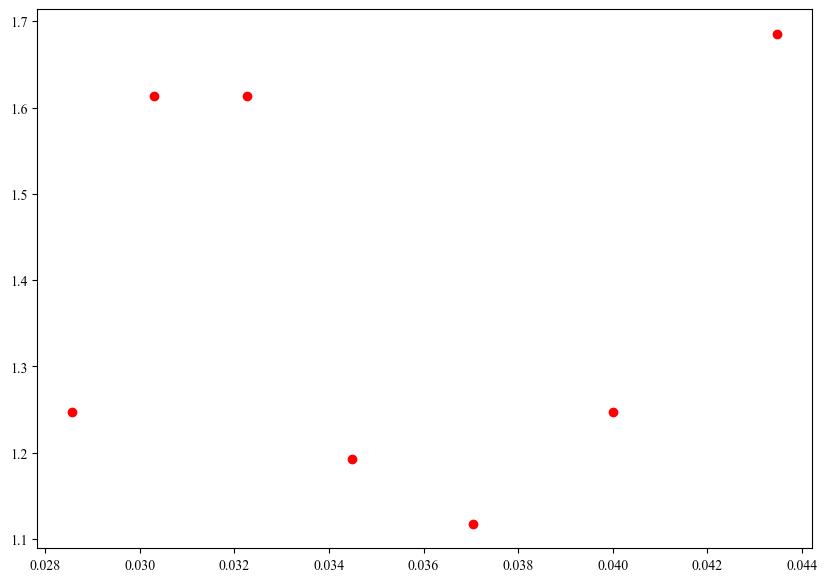

In [264]:
x_1 = [23,25,27,29,31,33,35]
x = 1/np.array(x_1)
minimos = np.array(minimos)
plt.figure(figsize=(10, 7))
plt.scatter(x, minimos, color='red', label='Mínimos')